## 01 - Ingest and Structure Transaction Data
The first step in measuring a portfolio's performance is to **collect and organize all transaction data**, including BUY, SELL, and Dividend events for each asset in the portfolio.

**Objective:**

In this notebook, I will define a structured format for recording all transactions throughout the portfolio’s management period. This structured dataset will form the foundation for accurately tracking the portfolio’s performance, value evolution, and the contribution of individual assets over time.

Here’s an example of an Excel sheet where I recorded the transactions of my portfolio, which I started in February 2023:

<img src="../images/transactions_template.jpg" alt="Transactions" width="900"/>

The portfolio is composed of three ETFs (tickers: **CSSPX**, **ITPS**, **EM710**) and one ETC (**PHAU**).
While some columns are self-explanatory, it is worth noting that **ISIN** stands for *International Securities Identification Number* — a unique 12-character code used to identify a specific financial security globally.
- **Shares** refer to the number of units bought or sold for a given security.
- **Amount** represents the total value of the transaction (BUY, SELL or Dividend).
- **Commissions** and **Taxes** are the costs associated with executing each transaction.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')

#### A. Reading all transactions (BUY/SELL/Dividends) per each Asset over time

In [3]:
# parsing dtypes
dtypes = {
    'ISIN': str,
    'Ticker': str,
    'Shares': int,
    'Amount': float,
    'Commissions': float,
    'Taxes': float,
}
# Load the specific sheet with transactions by name
transactions = pd.read_excel('../data/transactions_carlo.xlsx', 
                             sheet_name=0, dtype=dtypes, parse_dates=['Date'])

transactions.head()

,Date,Name,ISIN,Ticker,Type,Shares,Amount,Commissions,Taxes
0,2023-02-15,ISHARES CORE S&P 500 UCITS ETF USD ACC,IE00B5BMR087,CSSPX,BUY,63,25144.72,8.00,0.0
1,2023-02-15,ISHARES $ TIPS UCITS ETF USD ACC,IE00B1FZSC47,ITPS,BUY,117,24920.18,8.00,0.0
2,2023-02-15,WISDOMTREE PHYSICAL GOLD,JE00B1VS3770,PHAU,BUY,155,24946.03,8.00,0.0
3,2023-02-15,LXR EURO GOVERN BOND 7-10Y(DR) UCITS ETF,LU1287023185,EM710,BUY,162,25092.49,8.00,0.0
4,2024-02-27,ISHARES $ TIPS UCITS ETF USD ACC,IE00B1FZSC47,ITPS,BUY,28,5978.69,11.36,0.0


In [4]:
# checking that all data are in the right dtype
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         10 non-null     datetime64[ns]
 1   Name         10 non-null     object        
 2   ISIN         10 non-null     object        
 3   Ticker       10 non-null     object        
 4   Type         10 non-null     object        
 5   Shares       10 non-null     int32         
 6   Amount       10 non-null     float64       
 7   Commissions  10 non-null     float64       
 8   Taxes        10 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(4)
memory usage: 812.0+ bytes


Now, I will sort all transactions by `Date`, from the earliest to the latest.
I will also drop the `Name` and `ISIN` columns, keeping only the `Ticker` to identify each asset. 

I preceed with minus sign the number of shares and amounts of selling and dividend transactions. I follow the convention to take with positive sign all money that flows into the porfolio (including costs for `Commissions` and `Taxes`) and with minus sign all money that flows out of the portfolio (redemptions and dividends distributed).

Finally, I will set the sorted `Date` as the new index of the DataFrame.

In [5]:
# dropping 'Name' and 'ISIN' columns
transactions = transactions.drop(columns=['Name','ISIN'])

# Preceed with minus sign the number of shares and amount of the selling/dividends transactions
transactions.loc[transactions['Type'] == 'SELL','Shares'] *= -1
transactions.loc[transactions['Type'] == 'SELL','Amount'] *= -1
transactions.loc[transactions['Type'] == 'DIVIDEND','Amount'] *= -1

# sorting transactions by 'Date' and resetting index on 'Date'
transactions = transactions.sort_values(by=['Date','Ticker']).set_index('Date')

transactions

,Ticker,Type,Shares,Amount,Commissions,Taxes
Date,,,,,,
2023-02-15,CSSPX,BUY,63,25144.72,8.00,0.0
2023-02-15,EM710,BUY,162,25092.49,8.00,0.0
2023-02-15,ITPS,BUY,117,24920.18,8.00,0.0
2023-02-15,PHAU,BUY,155,24946.03,8.00,0.0
2024-02-27,EM710,BUY,30,4834.20,9.18,0.0
2024-02-27,ITPS,BUY,28,5978.69,11.36,0.0
2024-02-27,PHAU,BUY,21,3690.12,8.00,0.0
2025-02-14,CSSPX,BUY,21,13002.36,18.00,0.0
2025-02-14,EM710,BUY,9,1509.12,8.00,0.0


Now, I will wrap the above code for loading and preparing the transactions DataFrame into a clean function, making it easy to reuse and include in the `utils.py` file.

In [6]:
def load_transactions(excel_path, sheet_name=0):
    """
    Loads transaction data from an Excel file, parses dtypes, drops unnecessary columns,
    sorts by Date and Ticker, and sets Date as the index.

    Parameters:
    - excel_path: str, path to the Excel file
    - sheet_name: str or int, sheet name or position (default: 0)

    Returns:
    - transactions: pd.DataFrame, cleaned and sorted transaction data
    """
    
    # Define dtypes
    dtypes = {
        'ISIN': str,
        'Ticker': str,
        'Shares': int,
        'Amount': float,
        'Commissions': float,
        'Taxes': float,
    }

    # Load transactions
    transactions = pd.read_excel(
        excel_path, 
        sheet_name=sheet_name, 
        dtype=dtypes, 
        parse_dates=['Date']
    )

    # Drop unnecessary columns
    transactions = transactions.drop(columns=['Name', 'ISIN'])
    
    # Preceed with minus sign the number of shares and amount of the selling/dividends transactions
    transactions.loc[transactions['Type'] == 'SELL','Shares'] *= -1
    transactions.loc[transactions['Type'] == 'SELL','Amount'] *= -1
    transactions.loc[transactions['Type'] == 'DIVIDEND','Amount'] *= -1

    # Sort by Date and Ticker, set Date as index
    transactions = transactions.sort_values(by=['Date', 'Ticker']).set_index('Date')

    return transactions

In [7]:
# example usage of the function
excel_path = '../data/transactions_carlo.xlsx'
df_transacts = load_transactions(excel_path=excel_path, sheet_name=0)

#### B. Grouping Cash Flows by Date and Visualizing
Visualizing portfolio cash flows by `Date` helps track money movements, liquidity, and overall portfolio performance over time.

*Reminder*. I follow the convention to take with positive sign all money that flows into the porfolio (including costs for `Commissions` and `Taxes`) and with minus sign all money that flows out of the portfolio (redemptions and dividends distributed).

In [8]:
# reset the index for 'Date' to be a column
transactions.reset_index(inplace=True)

# grouping by 'Date' and summing by rows to calculate total cash flows on a given 'Date'
cash_flows = transactions.groupby('Date').sum()[['Amount','Commissions','Taxes']].sum(axis=1)

# naming the pd.Series 'Cash Flow'
cash_flows.name = 'Cash_Flows'

cash_flows

Date
2023-02-15    100135.42
2024-02-27     14531.55
2025-02-14      2278.61
Name: Cash_Flows, dtype: float64

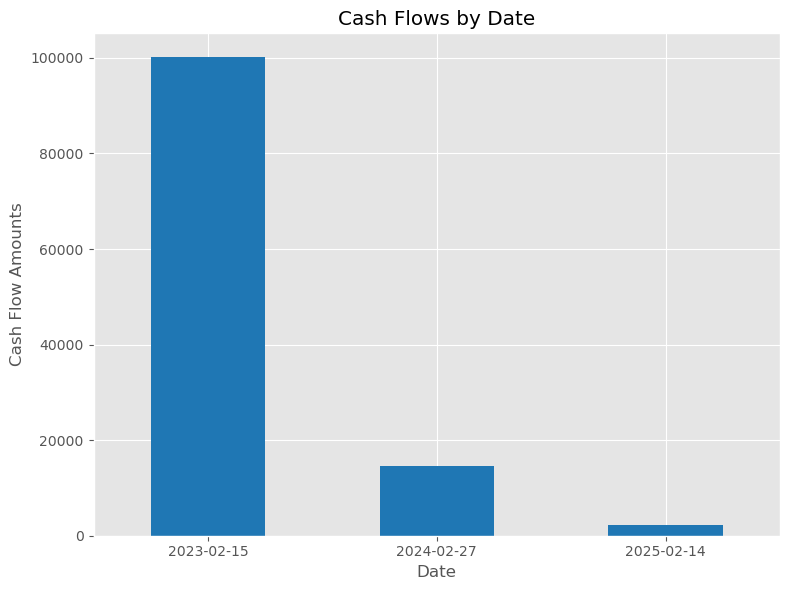

In [9]:
# Plotting the cash flows as a bar chart
ax = cash_flows.plot(kind='bar', figsize=(8, 6), cmap="tab20")

# Formatting the plot
plt.title('Cash Flows by Date')
plt.xlabel('Date')
plt.ylabel('Cash Flow Amounts')
    
# Format the x-tick labels to display YYYY-MM-DD and center them under each bar
ax.set_xticklabels([x.strftime('%Y-%m-%d') for x in cash_flows.index], rotation=0, ha='center')

plt.tight_layout()

# Show plot
plt.show()

Wrapping Cash Flow Calculations in a function for reuse:

In [10]:
def portfolio_cash_flows(transactions):
    """
    Calculate the daily cash flows from a transaction DataFrame.

    This function computes the net daily cash flows based on the 'Amount',
    'Commissions', and 'Taxes' columns. It groups transactions by 'Date'
    and sums the relevant columns to determine the total daily cash flow.

    Args:
        transactions (pd.DataFrame): A DataFrame containing at least the following columns:
            - 'Date' (datetime-like index or column)
            - 'Amount' (float): The transaction amount.
            - 'Commissions' (float): The commission fees associated with the transaction.
            - 'Taxes' (float): The taxes associated with the transaction.

    Returns:
        pd.Series: A time series (indexed by 'Date') representing the daily total cash flows.

    Notes:
        - If 'Date' is not a column but an index, it will be reset.
        - The resulting Series will have the name 'Cash_Flows'.
    """
    # Ensure 'Date' is a column (reset index only if needed)
    if transactions.index.name == 'Date':
        transactions = transactions.reset_index()

    # Group by 'Date' and sum the specified columns
    grouped = transactions.groupby('Date')[['Amount', 'Commissions', 'Taxes']].sum()

    # Calculate daily cash flow
    cash_flows = grouped.sum(axis=1)

    # Name the resulting Series
    cash_flows.name = 'Cash_Flows'

    return cash_flows

In [11]:
# Example usage
portfolio_cash_flows(df_transacts)

Date
2023-02-15    100135.42
2024-02-27     14531.55
2025-02-14      2278.61
Name: Cash_Flows, dtype: float64

### Summary
In this chapter, I explored how to load and structure portfolio transactions, and defined the `load_transactions()` function for easy reuse. 

Finally, I created the function `portfolio_cash_flows()` to better understand the portfolio’s financial movements over time and visualized the cash flows by `Date`. This function calculates portfolio cash flows from the transactions recorded.